In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt



### Loading and visualizing data

In [2]:
training_data = datasets.MNIST(root="../data", train=True, download=True, transform=transforms.ToTensor())
test_data = datasets.MNIST(root="../data", train=False, download=True, transform=transforms.ToTensor())

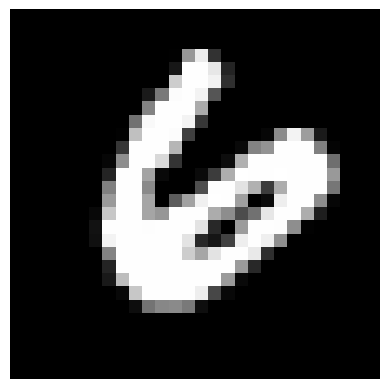

In [3]:
sample_idx = torch.randint(len(training_data), size=(1,)).item()
img, label = training_data[sample_idx]
plt.axis("off")
plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [4]:
img.size()

torch.Size([1, 28, 28])

In [5]:
train_loader = torch.utils.data.DataLoader(training_data, batch_size=32)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=32)

### Defining our model

In [6]:
class MnistModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1) #nn.Conv2d(1, 32, 3, 1, padding=(1,1)) for the padded version
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        ## after the 1st convolution, the ouput will have a size of (32, 26, 26)
        ## after the 2nd convolution, the ouput will have a size of (64, 24, 24)
        ## after pooling, the output will have a size of (64, 12, 12)
        ## after flatenning, the ouputput will have a size of 64 * 12 * 12 = 9216
        self.fc1 = nn.Linear(9216, 128) 
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

In [7]:
model = MnistModel()

### How to debug/develop

In [8]:
l = nn.Conv2d(1, 32, 3, 1, padding=(1,1))

In [9]:
t = l(training_data[1][0])

In [10]:
t.shape

torch.Size([32, 28, 28])

In [11]:
l2 = nn.Conv2d(32, 64, 3, 1)

In [12]:
l2(t).shape

torch.Size([64, 26, 26])

In [13]:
64 * 24 * 24 / 4

9216.0

In [14]:
len(training_data)

60000

### Writing training and evaluation codes

In [8]:
def train(model, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print(f'Train Epoch: {epoch} Loss: {loss.item():.6f}')
            

def test(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print(f'\nTest set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_data)}')



   
    

In [9]:
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)


In [10]:
trainable_params

1199882

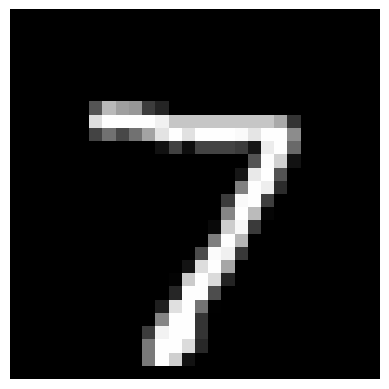

In [11]:
img, label = test_data[0]
plt.axis("off")
plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [19]:
model.eval()
with torch.no_grad():
    predicted_result = model(test_data[0][0].unsqueeze(dim=0))

In [21]:
predicted_result.argmax()

tensor(4)

In [16]:
test_data[0][0].shape

torch.Size([1, 28, 28])

In [16]:
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = StepLR(optimizer, step_size=1, gamma=0.1)
for epoch in range(1, 10 + 1):
    train(model, train_loader, optimizer, epoch)
    test(model, test_loader)
    scheduler.step()


Train Epoch: 1 Loss: 2.313071
Train Epoch: 1 Loss: 0.472216
Train Epoch: 1 Loss: 0.175738
Train Epoch: 1 Loss: 0.311754
Train Epoch: 1 Loss: 0.123183
Train Epoch: 1 Loss: 0.413600
Train Epoch: 1 Loss: 0.119312
Train Epoch: 1 Loss: 0.133769
Train Epoch: 1 Loss: 0.191937
Train Epoch: 1 Loss: 0.087185
Train Epoch: 1 Loss: 0.250072
Train Epoch: 1 Loss: 0.138338
Train Epoch: 1 Loss: 0.231149
Train Epoch: 1 Loss: 0.107408
Train Epoch: 1 Loss: 0.062320
Train Epoch: 1 Loss: 0.158484
Train Epoch: 1 Loss: 0.018901
Train Epoch: 1 Loss: 0.018791
Train Epoch: 1 Loss: 0.036233

Test set: Average loss: 0.0522, Accuracy: 9836/10000
Train Epoch: 2 Loss: 0.042613
Train Epoch: 2 Loss: 0.180454
Train Epoch: 2 Loss: 0.170956
Train Epoch: 2 Loss: 0.050528
Train Epoch: 2 Loss: 0.039188
Train Epoch: 2 Loss: 0.159708
Train Epoch: 2 Loss: 0.049851
Train Epoch: 2 Loss: 0.010633
Train Epoch: 2 Loss: 0.129443
Train Epoch: 2 Loss: 0.034566
Train Epoch: 2 Loss: 0.151554
Train Epoch: 2 Loss: 0.086441
Train Epoch: 2 L

KeyboardInterrupt: 